# Imports and constants

In [1]:
from PIL import Image
import os
from matplotlib import pyplot as plt
import cv2
import numpy as np
from typing import Callable

TEST_IMAGE_DIR = '../data/test_images'

# Experiments

## Preprocessing

In [2]:
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

In [3]:
def show_processing_steps(image, steps: list[Callable]):
    cols = len(steps)+2
    plt.figure(figsize=(10, 5*cols))
    plt.subplot(1, cols, 1)
    plt.axis('off')
    plt.title('Original')
    plt.imshow(image)

    plt.subplot(1, cols, 2)
    plt.axis('off')
    plt.title('Grayscale')
    grayscale = get_grayscale(image)
    plt.imshow(grayscale, cmap='gray')

    for idx, step in enumerate(steps, start=3):
        img = step(grayscale)
        plt.subplot(1, cols, idx)
        plt.axis('off')
        plt.title(str(step.__name__))
        plt.imshow(img, cmap='gray')

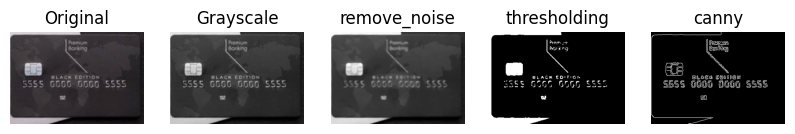

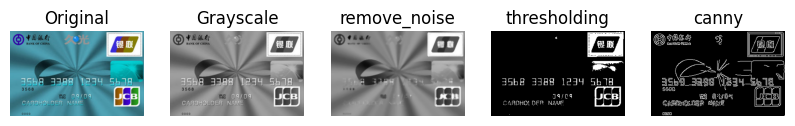

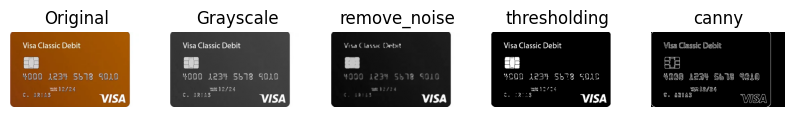

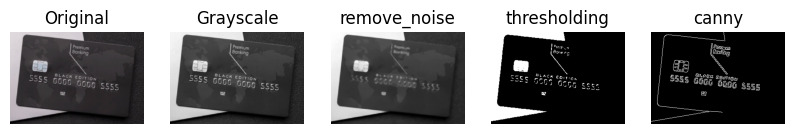

In [4]:
for filename in os.listdir(TEST_IMAGE_DIR):
    img = cv2.imread(os.path.join(TEST_IMAGE_DIR, filename))
    show_processing_steps(img, [remove_noise, thresholding, canny])
    

## Tesseract OCR

In [5]:
import pytesseract

In [6]:
for filename in os.listdir(TEST_IMAGE_DIR):
    img = Image.open(os.path.join(TEST_IMAGE_DIR, filename))
    print(filename)
    text = pytesseract.image_to_string(img)
    print(text)

image_rotated.png

image copy.png
SEBS8 3388409234 GhiIB


card1.png
Visa Classic Debit

4000 123% SbI8 9010
wr12/24

C. ARIAS V’SA


image.png
Ack g

OiTion

GO




### Conclusion:
The results from Tesseract OCR are not that good. It struggles a lot with non-black text and the font that's usually used on the bank cards.

## PaddleOCR

In [7]:
from paddleocr import PaddleOCR
from paddleocr.ppocr.utils.logging import get_logger
import logging
logger = get_logger()
logger.setLevel(logging.ERROR)

which: no ccache in (/home/lopharb/Documents/personal/cardfinder/.venv/bin:/usr/local/sbin:/usr/local/bin:/usr/bin:/usr/lib/jvm/default/bin:/usr/bin/site_perl:/usr/bin/vendor_perl:/usr/bin/core_perl)
/home/lopharb/Documents/personal/cardfinder/.venv/lib/python3.13/site-packages/paddle/utils/cpp_extension/extension_utils.py:711: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)


In [16]:
ocr = PaddleOCR(use_angle_cls=True, lang='en')

for filename in os.listdir(TEST_IMAGE_DIR):

    img = cv2.imread(os.path.join(TEST_IMAGE_DIR, filename))
    print(filename)
    results = ocr.ocr(img, cls=False)
    for line in results[0]:
        print(line)

image_rotated.png
[[[144.0, 22.0], [190.0, 24.0], [189.0, 36.0], [143.0, 33.0]], ('Premium', 0.9277868866920471)]
[[[141.0, 33.0], [191.0, 36.0], [190.0, 51.0], [140.0, 48.0]], ('Banking', 0.9594765305519104)]
[[[98.0, 105.0], [219.0, 104.0], [219.0, 119.0], [98.0, 120.0]], ('SLACK EDITION', 0.9511495232582092)]
[[[30.0, 118.0], [86.0, 118.0], [86.0, 139.0], [30.0, 139.0]], ('5555', 0.9972487688064575)]
[[[96.0, 119.0], [220.0, 122.0], [220.0, 140.0], [95.0, 138.0]], ('00000000', 0.8510949611663818)]
[[[211.0, 118.0], [284.0, 118.0], [284.0, 139.0], [211.0, 139.0]], ('05555', 0.9189993739128113)]
image copy.png
[[[39.0, 23.0], [89.0, 23.0], [89.0, 33.0], [39.0, 33.0]], ('ANK OF CHINA', 0.9273713231086731)]
[[[26.0, 106.0], [141.0, 106.0], [141.0, 120.0], [26.0, 120.0]], ('85683388', 0.8924846053123474)]
[[[156.0, 101.0], [276.0, 104.0], [276.0, 124.0], [155.0, 121.0]], ('12345678', 0.9652270078659058)]
[[[25.0, 125.0], [55.0, 125.0], [55.0, 136.0], [25.0, 136.0]], ('3568', 0.9967430233

### Conclusion
Paddle OCR does a pretty good job at detecting text on bank cards. It's also a lot faster than Tesseract.
A large advantage of Paddle OCR is that it can detect text in rotated images thanks to it's built-int angle classifier. However, there's a problem that some of the numbers are detected as upside-down letters (for example `4` can be recognized as `h`).

Paddle OCR overall gives satisfactory results, so we'll move to pre-/post-processing from now.